###  Kittylyst demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
%matplotlib inline

In [2]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [3]:
from kittylyst import (
    MicroLoader, MicroCriterion, MicroOptimizer, MicroScheduler,
    Experiment, IRunner,SupervisedRunner, Callback,
    CriterionCallback, AccuracyCallback, 
    OptimizerCallback, SchedulerCallback,
    LoggerCallback
)

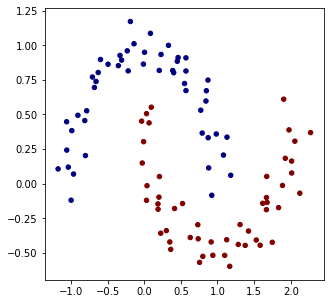

In [4]:
# make up a dataset
def make_dataset(seed=42, n_samples=100):
    np.random.seed(seed)
    random.seed(seed)
    X, y = make_moons(n_samples=100, noise=0.1)

    y = y*2 - 1 # make y be -1 or 1
    return X, y

def visualize_dataset(X, y):
    plt.figure(figsize=(5,5))
    plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

# let's create train data
X_train, y_train = make_dataset()
visualize_dataset(X_train, y_train)

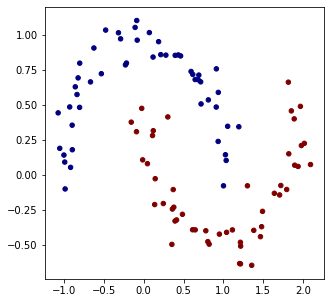

In [5]:
# valid data
X_valid, y_valid = make_dataset(seed=137)
visualize_dataset(X_valid, y_valid)

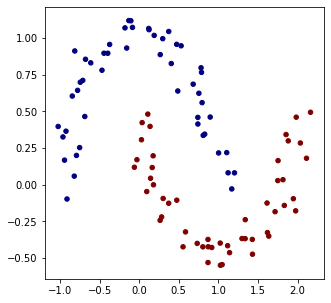

In [6]:
# and another train one (why not?)
X_train2, y_train2 = make_dataset(seed=1337)
visualize_dataset(X_train2, y_train2)

In [7]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [8]:
def visualize_decision_boundary(X, y, model):
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

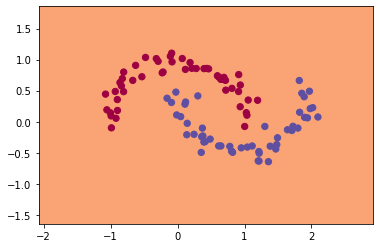

In [9]:
visualize_decision_boundary(X_valid, y_valid, model)

In [10]:
loaders = {
    "train_1": MicroLoader(X_train, y_train), 
    "train_2": MicroLoader(X_train2, y_train2), 
    "valid": MicroLoader(X_valid, y_valid), 
}

---

### Act 1 - ``CustomRunner`` solution

Suppose you have your favorite `for-loop` pipeline and want to get rid of `for-for-for` stuff to make code more clean. In this case you can define your own ``CustomRunner`` with ``_handle_batch`` method and just run it.

Whole ``Runner`` source code is located [here](github.com/Scitator/kittylyst/blob/master/kittylyst/runner.py) (~100 lines of code).

In [11]:
model = MLP(2, [16, 16, 1])
experiment = Experiment(model=model, loaders=loaders, num_epochs=10)

class CustomRunner(IRunner):
    def _handle_batch(self, batch):
        features, targets = batch
        scores = list(map(self.model, features))
        
        losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(targets, scores)]
        data_loss = sum(losses) * (1.0 / len(losses))
        # L2 regularization
        alpha = 1e-4
        reg_loss = alpha * sum((p*p for p in self.model.parameters()))
        total_loss = data_loss + reg_loss

        # also get accuracy
        accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(targets, scores)]
        accuracy = sum(accuracy) / len(accuracy)
        
        print(f"{self.loader_name}: accuracy {accuracy}, loss {total_loss.data}")
        
        if self.is_train_loader:
            # backward
            self.model.zero_grad()
            total_loss.backward()

            # update (sgd)
            learning_rate = 1.0 - 0.9 * self.epoch / self.num_epochs
            for p in self.model.parameters():
                p.data -= learning_rate * p.grad

CustomRunner().run_experiment(experiment)

train_1: accuracy 0.15625, loss 1.3142614940551327
train_1: accuracy 0.78125, loss 0.6598317508322048
train_1: accuracy 0.75, loss 0.7927354575997964
train_1: accuracy 0.625, loss 1.8240299288726267
train_1: accuracy 0.5625, loss 0.6996691628006418
train_1: accuracy 0.875, loss 0.3762774678655899
train_1: accuracy 0.875, loss 0.46448401507996706
train_1: accuracy 0.84375, loss 0.313181864574222
train_1: accuracy 0.875, loss 0.41924003695879297
train_1: accuracy 0.875, loss 0.29237872504797224
train_2: accuracy 0.84375, loss 0.36252849347984367
train_2: accuracy 0.90625, loss 0.23049635069090824
train_2: accuracy 0.90625, loss 0.2861263243941025
train_2: accuracy 0.90625, loss 0.2427632314364521
train_2: accuracy 0.90625, loss 0.2260113554087449
train_2: accuracy 0.9375, loss 0.17427040073732888
train_2: accuracy 0.90625, loss 0.2317996487584881
train_2: accuracy 0.9375, loss 0.15078985747720192
train_2: accuracy 0.90625, loss 0.291187602523029
train_2: accuracy 0.84375, loss 0.34327541

train_2: accuracy 1.0, loss 0.06262789574436402
train_2: accuracy 0.9375, loss 0.14211528990261274
train_2: accuracy 1.0, loss 0.012178329938574069
valid: accuracy 1.0, loss 0.012175650853345378
valid: accuracy 1.0, loss 0.012175650853345378
valid: accuracy 1.0, loss 0.0552963937617486
valid: accuracy 0.96875, loss 0.05951537482014667
valid: accuracy 1.0, loss 0.012175650853345378
valid: accuracy 0.96875, loss 0.05951537482014667
valid: accuracy 1.0, loss 0.012175650853345378
valid: accuracy 0.96875, loss 0.05951537482014667
valid: accuracy 1.0, loss 0.012175650853345378
valid: accuracy 1.0, loss 0.026003603338947308
train_1: accuracy 1.0, loss 0.02359830746140827
train_1: accuracy 1.0, loss 0.01693466144325532
train_1: accuracy 1.0, loss 0.02860660368117522
train_1: accuracy 1.0, loss 0.012200021055133896
train_1: accuracy 1.0, loss 0.012787235737884277
train_1: accuracy 1.0, loss 0.012204768502279141
train_1: accuracy 1.0, loss 0.012202522928175879
train_1: accuracy 1.0, loss 0.01220

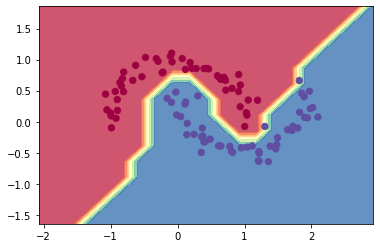

In [12]:
visualize_decision_boundary(X_valid, y_valid, model)

---

### Act 2 - ``SupervisedRunner`` solution

Let's make a bit more abstract. Let's introduce ``SupervisedRunner``, that knows how to execute Supervised models and ``CriterionCallback/OptimizerCallback/SchedulerCallback`` for typical criterions/optimizers/schedulers steps. 

Additionaly let's wrap accuracy with ``AccuracyCallback``, as far as metrics are general too. 

Finally, let's make our logs looks consistent with ``LoggerCallback``.

Whole ``Callback`` source code is located [here](github.com/Scitator/kittylyst/blob/master/kittylyst/callback.py) (~100 lines of code).

In [13]:
model = MLP(2, [16, 16, 1])
criterion = MicroCriterion()
optimizer = MicroOptimizer(model)
scheduler = MicroScheduler(optimizer, num_epochs=10)
experiment = Experiment(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    loaders=loaders, 
    num_epochs=10,
    callbacks=[
        CriterionCallback(), 
        AccuracyCallback(), 
        OptimizerCallback(), 
        SchedulerCallback(),
        LoggerCallback(),
    ],
    verbose=False,
)

SupervisedRunner().run_experiment(experiment)

1/10 Epoch (train_1) accuracy: 0.71875 loss: 0.785281554267671
1/10 Epoch (train_2) accuracy: 0.73125 loss: 0.7427673170707891
1/10 Epoch (valid) accuracy: 0.753125 loss: 0.6237755706891819
2/10 Epoch (train_1) accuracy: 0.725 loss: 0.873129456211746
2/10 Epoch (train_2) accuracy: 0.903125 loss: 0.27634106504414263
2/10 Epoch (valid) accuracy: 0.85625 loss: 0.3620674022545227
3/10 Epoch (train_1) accuracy: 0.95 loss: 0.1447585259765843
3/10 Epoch (train_2) accuracy: 0.98125 loss: 0.06889329382392614
3/10 Epoch (valid) accuracy: 0.9625 loss: 0.07871991095724752
4/10 Epoch (train_1) accuracy: 0.96875 loss: 0.09869389158524669
4/10 Epoch (train_2) accuracy: 0.990625 loss: 0.04151205921220884
4/10 Epoch (valid) accuracy: 0.996875 loss: 0.02621252590693186
5/10 Epoch (train_1) accuracy: 0.99375 loss: 0.03757581261556087
5/10 Epoch (train_2) accuracy: 0.9875 loss: 0.04990766902591705
5/10 Epoch (valid) accuracy: 0.99375 loss: 0.02435732621803047
6/10 Epoch (train_1) accuracy: 0.99375 loss: 0

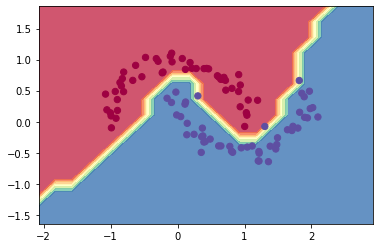

In [14]:
visualize_decision_boundary(X_valid, y_valid, model)

---

### Act 3 - ``CustomExperiment`` solution - multi-stage experiment with ``VisualizationCallback``

Let's go even harder. Suppose we want to firstly train our model on `train_1` data, and only after that - on `train_2`. This case could be easily handled with ``CustomExperiment``, where you could redefine your experiment components for each stage of your experiment.

Whole ``Experiemnt`` source code is located [here](github.com/Scitator/kittylyst/blob/master/kittylyst/experiment.py) (~100 lines of code).

1/10 Epoch (train_1) accuracy: 0.71875 loss: 0.785281554267671
1/10 Epoch (valid) accuracy: 0.721875 loss: 0.6940299711337519
2/10 Epoch (train_1) accuracy: 0.825 loss: 0.5505549582580421
2/10 Epoch (valid) accuracy: 0.878125 loss: 0.5176625016049039
3/10 Epoch (train_1) accuracy: 0.840625 loss: 0.4816616578259919
3/10 Epoch (valid) accuracy: 0.86875 loss: 0.25247263037071416
4/10 Epoch (train_1) accuracy: 0.940625 loss: 0.14985338301717985
4/10 Epoch (valid) accuracy: 0.978125 loss: 0.11139035194477467
5/10 Epoch (train_1) accuracy: 0.94375 loss: 0.1643548936585497
5/10 Epoch (valid) accuracy: 0.984375 loss: 0.11174302043807763
6/10 Epoch (train_1) accuracy: 0.98125 loss: 0.08354336042231081
6/10 Epoch (valid) accuracy: 0.975 loss: 0.05898081107929618
7/10 Epoch (train_1) accuracy: 0.990625 loss: 0.051306623433875244
7/10 Epoch (valid) accuracy: 1.0 loss: 0.032472787227006895
8/10 Epoch (train_1) accuracy: 1.0 loss: 0.023781156996373325
8/10 Epoch (valid) accuracy: 1.0 loss: 0.0434024

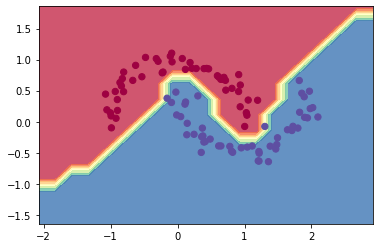

1/10 Epoch (train_2) accuracy: 1.0 loss: 0.015204068895861076
1/10 Epoch (valid) accuracy: 0.984375 loss: 0.04979577101262032
2/10 Epoch (train_2) accuracy: 1.0 loss: 0.01809742569123933
2/10 Epoch (valid) accuracy: 0.98125 loss: 0.08383076867659356
3/10 Epoch (train_2) accuracy: 0.984375 loss: 0.08231697447288436
3/10 Epoch (valid) accuracy: 0.828125 loss: 0.4213829661783479
4/10 Epoch (train_2) accuracy: 0.890625 loss: 0.3243339002094888
4/10 Epoch (valid) accuracy: 0.996875 loss: 0.09912316988030219
5/10 Epoch (train_2) accuracy: 0.996875 loss: 0.04078078209342447
5/10 Epoch (valid) accuracy: 0.975 loss: 0.05557860372341974
6/10 Epoch (train_2) accuracy: 1.0 loss: 0.022288604992755146
6/10 Epoch (valid) accuracy: 1.0 loss: 0.029794771150518633
7/10 Epoch (train_2) accuracy: 1.0 loss: 0.019741230552452572
7/10 Epoch (valid) accuracy: 0.971875 loss: 0.05227168965444916
8/10 Epoch (train_2) accuracy: 1.0 loss: 0.0148558049132897
8/10 Epoch (valid) accuracy: 0.98125 loss: 0.038436644874

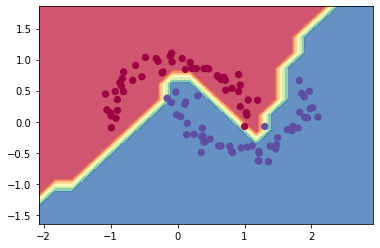

In [15]:
class CustomExperiment(Experiment):
    @property
    def stages(self):
        return self._stage

    def get_loaders(self, stage: str):
        return self._loaders[stage]

    
class VisualizationCallback(Callback):
    def on_stage_end(self, runner):
        visualize_decision_boundary(X_valid, y_valid, runner.model)


loaders = {
    "loader_1": {
        "train_1": MicroLoader(X_train, y_train), 
        "valid": MicroLoader(X_valid, y_valid), 
    },
    "loader_2": {
        "train_2": MicroLoader(X_train2, y_train2), 
        "valid": MicroLoader(X_valid, y_valid), 
    },
}
model = MLP(2, [16, 16, 1])
criterion = MicroCriterion()
optimizer = MicroOptimizer(model)
scheduler = MicroScheduler(optimizer, num_epochs=10)
experiment = CustomExperiment(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    loaders=loaders, 
    num_epochs=10,
    callbacks=[
        CriterionCallback(), 
        AccuracyCallback(), 
        OptimizerCallback(), 
        SchedulerCallback(),
        LoggerCallback(),
        VisualizationCallback(),  # <-- here is our new Callback
    ],
    verbose=False,
    stage=loaders.keys()  # <-- here is the trick for multi-stage support
)

SupervisedRunner().run_experiment(experiment)

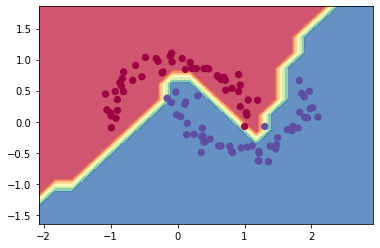

In [16]:
visualize_decision_boundary(X_valid, y_valid, model)

---

🎉 You have passed ``Kittylyst`` tutorial! This is just a minimal educational demo, but I hope you found it interesting for your deep learning research code organisation.

For more advanced and production-ready solution please follow our [Catalyst](https://github.com/catalyst-team/catalyst) repository.

PS. If you are interested in deep learning you could also try out our [dl-course](https://github.com/catalyst-team/dl-course).